# 1. Import libraries

In [4]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
from pypinyin import pinyin, lazy_pinyin, Style
import matplotlib
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate import bleu
from copy import deepcopy

from utils import *
# Define a device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
import numpy as np
a = np.array([123])

In [6]:
a

array([123])

# 2. Define Helper Functions

In [7]:
def prepare_data(in_path,out_path,with_all_couplets=True):
    batch_size = 1 
    nb_couplets = 1024
    
    print("### data preparing ### ")
    print("Batch size is: ",batch_size)
    print("Use all couplets to train: ",with_all_couplets)
    if (with_all_couplets==False):
        print("\tTherefore nb_couplets to train is: ",nb_couplets)

    print("### data loading ### ")
    vocab_path = "./vocab.txt"
    data_in, data_out, max_length = load_data(in_path,out_path,nb_couplets,with_all_couplets)
    vocab = load_vocab(vocab_path)
    vocab_size = len(vocab)
    print("Vocab length is ", vocab_size)
    return data_in,data_out,vocab,max_length

def create_dicts(data_in,data_out,vocab,max_length):

    # create char2int and int2char_dict
    char2int_dict, int2char_dict = create_char2int_and_int2char_dict(vocab)
    
    char2tone_dict = create_char2tone_dict(vocab)
    
    int2tone_dict = dict()
    for i in range(len(vocab)):
        t = char2tone_dict.get(vocab[i])
        int2tone_dict[i] = t

    return char2int_dict, int2char_dict, char2tone_dict, int2tone_dict
        
        
def create_tone_mask(vocab, char2tone_dict):
    tone_onlyP_2 = np.ones(len(vocab))
    tone_onlyZ_2 = np.ones(len(vocab))
    tone_onlyZ_2[:4] = 92233720368547758  # remove PAD, SOS,EOS and UNK
    tone_onlyZ_2[:4] = 92233720368547758
    for i in range(4,len(vocab)):
        # i  <=> char_id   
        tone = char2tone_dict.get(vocab[i])
        if (tone.isalpha()):
            if (len(tone) != 2):
                if(tone == 'P'):
                    tone_onlyP_2[i] = 92233720368547758
                else:
                    tone_onlyZ_2[i] = 92233720368547758
    return tone_onlyP_2, tone_onlyZ_2

    
# tokenize: couplet to int 
def tokenize_(data, char2int_dict, max_length):  
    v=[]
    for i in range(0, len(data)):
        l = []
        for j in range (0, len(data[i])):
            if ( char2int_dict.get(data[i][j])  is None ):
                l.append(   char2int_dict.get('UNK')  )
            else:
                l.append(   char2int_dict.get(data[i][j])  )
        if (len(data[i]) < max_length):   # padding 0(pad) at the end
            l = (l + [0] * max_length)[:max_length]
        v.append(l)
    return v


def tokenize_dec_in_(data, char2int_dict, max_length): 
    v=[]
    for i in range(0, len(data)):
        l = [char2int_dict.get('sos')]

        for j in range (0, len(data[i])):
            if ( char2int_dict.get(data[i][j])  is None ):
                l.append(   char2int_dict.get('UNK')  )
            else:
                l.append(   char2int_dict.get(data[i][j])  )
        if (len(data[i]) < max_length):   # padding 0(pad) at the end
            l = (l + [0] * max_length)[:max_length]
        v.append(l)
    return v


def tokenize_dec_out_(data, char2int_dict, max_length): 
    v=[]
    for i in range(0, len(data)):
        l = []
        for j in range (0, len(data[i])):
            if ( char2int_dict.get(data[i][j])  is None ):
                l.append(   char2int_dict.get('UNK')  )
            else:
                l.append(   char2int_dict.get(data[i][j])  )

        l.append(char2int_dict.get('eos'))
        if (len(data[i]) < max_length):   # padding 0(pad) at the end
            l = (l + [0] * max_length)[:max_length]
        v.append(l)
    return v

def tokenization(data_in,data_out,char2int_dict,max_length):
    # Line One from character to int
    Enc_in =  tokenize_(data_in,char2int_dict,max_length)
    # Line two from character to int, with SOS and EOS
    token_out =tokenize_(data_out,char2int_dict,max_length)
    Dec_in = tokenize_dec_in_(data_out,char2int_dict,max_length)
    Dec_out = tokenize_dec_out_(data_out,char2int_dict,max_length)  
    
    return  Enc_in,Dec_in,Dec_out

def prepare_batches(Enc_in,Dec_out,Dec_in,batch_size=1):
    in_ = []
    for i in range(0,int(len(Enc_in)/batch_size)):
        in_.append( torch.Tensor(Enc_in[batch_size*i:batch_size*(i+1)]).to(torch.int64) )
    out_ = []
    for i in range(0,int(len(Dec_out)/batch_size)):
        out_.append( torch.Tensor(Dec_out[batch_size*i:batch_size*(i+1)]).to(torch.int64) )
    dec_in_ =[]
    for i in range(0,int(len(Dec_in)/batch_size)):
        dec_in_.append( torch.Tensor(Dec_in[batch_size*i:batch_size*(i+1)]).to(torch.int64) )
    batch_in_out_pairs =[]   # may ignore some last couplets
    for i in range(0, len(in_)):
        batch_in_out_pairs.append((in_[i],dec_in_[i], out_[i]))
    print("Number of couplet batches :",len(batch_in_out_pairs))
    
    return batch_in_out_pairs


class Node:
    def __init__(self,indices,acc,hid,attn):
        self.indices = indices
        self.acc = acc
        self.hid = hid
        self.attn = attn

        
    def add_vi(self,val_,idx_,hid,attn):
        self.indices.append(idx_)
        self.acc = val_
        self.hid.append(hid)
        self.attn.append(attn)
    
    def printf(self):
        print("=> In Node:")
        print("=> Acc is: ",float(self.acc))
        print("=> Indices are:", [i for i in self.indices])

def detokenize_All(couplets, int2char_dict):
    o = ''
    for i in range(0, len(couplets)):
        for j in range(len(couplets[i])):
            if (couplets[i][j] >= 3):    # ignore pad,sos,eos
                o = o + int2char_dict.get(couplets[i][j].item()) 
        #o = o +"\n"
    return o

def detokenize_int(one_couplet, int2char_dict):
    o = ''
    for i in range(0, len(one_couplet)):
        if(int2char_dict.get(one_couplet[i]) is not None):
            o = o + int2char_dict.get(one_couplet[i])   # one_couplet should be like [24,576,134]
        else:
            print("what")
    return o


# create a dictionary of repeted words
def dict_repet_idx(one_tensor,length):
    records_array = np.array(one_tensor)[:length]
    vals, inverse, count = np.unique(records_array, return_inverse=True,return_counts=True)
    idx_vals_repeated = np.where(count > 1)[0]
    vals_repeated = vals[idx_vals_repeated]

    rows, cols = np.where(inverse == idx_vals_repeated[:, np.newaxis])
    _, inverse_rows = np.unique(rows, return_index=True)
    res = np.split(cols, inverse_rows[1:])
    
    d = dict()
    for i in range(len(res)):
        for l in range(1,len(res[i])):
            val = res[i][0]
            d[ res[i][l] ]  = val
    
    return d


# If input couplet consists of some same characters
# Then this method forces the output couplet to have same character at corresponding position
def detokenize_int_repet(input_tensor, one_couplet, int2char_dict):
    o = ''
    longueur = np.where(np.array(input_tensor[0]) == 0)[0][0]
    d = dict_repet_idx(input_tensor[0],longueur)
    #print("Input length is ",longueur)
    
    for i in range(0, len(one_couplet)):
        idx = d.get(i)
        if ( idx is not None ):
            # use the first appreared word
            o = o + int2char_dict.get(one_couplet[idx])
        else:
            o = o + int2char_dict.get(one_couplet[i])
    return o


# Evaluate one couplet
def evaluate(char2tone_dict,encoder, decoder,input_tensor,forced_tone=True,forced_word=True, beam_width=1, max_length=33):
    
    batch_size = input_tensor.size(0)
    target_length = input_tensor.size(1)
    ini_mask = np.ones(len(vocab))
    ini_mask[:4] = 92233720368547758  # masking PAD, SOS, EOS and UNK
    ini_mask[input_tensor] = 92233720368547758 # masking characters in inputs
    ini_mask[4] = 1
    
    encoder.eval()
    decoder.eval()
    
    longueur = [np.where(np.array(input_tensor[0]) == 0)[0][0]]
    with torch.no_grad():
        encoder_hidden = torch.zeros(2, batch_size, hidden_size)
        encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden,longueur)
        decoder_input = torch.tensor([1])
        decoder_hidden = encoder_hidden
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input.to(device), decoder_hidden.to(device), encoder_outputs.to(device))
        
        decoder_output = decoder_output*torch.Tensor(ini_mask)
        
        if(forced_tone):
            tone = int2tone_dict.get(int(input_tensor[0][0]))
            if( tone is not None and tone.isalpha() and len(tone) != 2 ):

                if (tone == 'P'):
                    decoder_output = decoder_output*torch.Tensor(tone_onlyP_2)
                else:
                    decoder_output = decoder_output*torch.Tensor(tone_onlyZ_2)        
        
        
        topv, topi = decoder_output.squeeze(1).topk(beam_width)
        
        decoder_input = topi.detach().t() # t() for convenience dec_in shape
        
        list_nodes = []
        init_node = Node( [], 0,[],[])  # indices,acc,hid,attn
        for l in range(0,beam_width):
            node = deepcopy(init_node)
            node.add_vi(topv[0][l],int(topi[0][l]),decoder_hidden,decoder_attention)
            list_nodes.append(node)  

        for j in range (1,longueur[0]):
            temp_val = []
            temp_idx = []
            temp_hid = []
            temp_attn = []
            for b in range(beam_width):
                decoder_output, decoder_hidden, decoder_attention = decoder(torch.tensor([ list_nodes[b].indices[-1] ]), list_nodes[b].hid[-1], encoder_outputs)
                ###
                unwanted = torch.tensor( list_nodes[b].indices)
                ini_mask[unwanted] = 92233720368547758 # masking characters in inputs
                ###
                decoder_output = decoder_output*torch.Tensor(ini_mask)
                
                if(forced_tone):
                    tone = int2tone_dict.get(int(input_tensor[0][j]))
                    if( tone is not None and tone.isalpha() and len(tone) != 2 ):
                        
                        if (tone == 'P'):
                            decoder_output = decoder_output*torch.Tensor(tone_onlyP_2)  
                        else:
                            decoder_output = decoder_output*torch.Tensor(tone_onlyZ_2)   
                            
                
                topv, topi = decoder_output.squeeze(1).topk(beam_width)
                
                temp_val.append(topv) 
                temp_idx.append(topi)
                temp_hid.append(decoder_hidden)
                temp_attn.append(decoder_attention)
                
            for bb in range(beam_width):
                temp_val[bb] += list_nodes[bb].acc 
            
            concat = temp_val[0]
            concat_idx = temp_idx[0]
            concat_hid = []
            concat_hid.append(temp_hid[0])
            concat_attn = []
            concat_attn.append(temp_attn[0])
            for bbb in range(1,beam_width):
                concat = torch.cat((concat,temp_val[bbb]),dim=1)
                concat_idx = torch.cat((concat_idx,temp_idx[bbb]),dim=1)
                concat_hid.append(temp_hid[bbb])
                concat_attn.append(temp_attn[bbb])
            concat = concat.squeeze()
            concat_idx = concat_idx.squeeze()
            if(beam_width == 1):
                concat = concat.unsqueeze(0)
                concat_idx = concat_idx.unsqueeze(0)

            tv, ti = concat.topk(beam_width)

            new_list_nodes = []
            for bbbb in range(beam_width):
                quel_node =  int(int(ti[bbbb]) / beam_width)
                corr_nodes = list_nodes[quel_node] 

                new = deepcopy(corr_nodes)
                new.add_vi(concat[ti[bbbb]], int(concat_idx[ti[bbbb]]),concat_hid[quel_node],concat_attn[quel_node] )

                new_list_nodes.append(deepcopy(new))

            new_dec_in = []
            for e in range(len(new_list_nodes)):
                nn = new_list_nodes[e]
                new_dec_in.append(nn.indices[-1])
            new_dec_in = torch.tensor(new_dec_in).unsqueeze(1)
            
            list_nodes = deepcopy(new_list_nodes)
            decoder_input = new_dec_in

        decoded_words=[]
        for kk in range(len(list_nodes)):
            nnn = list_nodes[kk]
            d = nnn.indices
            
            if (forced_word):
                decoded_words.append( detokenize_int_repet(input_tensor, d, int2char_dict) )
            else:
                decoded_words.append( detokenize_int(d, int2char_dict) )
    return decoded_words, list_nodes
            
    
# evaluate randomly n couplets
def evaluateRandomly(char2tone_dict,encoder, decoder,forced_tone=True,forced_word=False,beam_width=1, n=1):
    # save locally couplet outputs
    f = open("./couplet_outputs.txt","a")
    for i in range(n):
        
        i = np.random.randint(len(Enc_in))
        
        j = np.random.randint(len(Enc_in))
        pair = torch.Tensor([Enc_in[i] ]).to(torch.int64)
        d_out =torch.Tensor([Dec_in[i] ]).to(torch.int64)
        output_words, list_nodes = evaluate(char2tone_dict,encoder, decoder, pair,forced_tone,forced_word,beam_width)
        output_words_line = '\n'.join(output_words)
        f.write(str(i))
        f.write("\n")
        print("in: ")
        inn = detokenize_All(pair, int2char_dict)
        print(inn)
        f.write(inn)
        f.write("\n")
        print('model answer: ')
        print(output_words_line)
        f.write(output_words_line)
        f.write("\n")
        print("desired answer: ")
        outt = detokenize_All(d_out, int2char_dict)
        print(outt)
        f.write(outt)
        f.write("\n")
        print("\n")
        
        
        # Plot the attention and save it locally
        attn = []
        for w in range(len(list_nodes)):
            #print("w is ",w)
            a = list_nodes[w].attn
            #print("len attn",len(a))
            attn_tmp = torch.tensor(())
            for m in range(len(a)):
                b = torch.tensor(a[m][0])
                #plt.subplots(figsize=(5, 9))
                #plt.imshow(b,cmap='hot')
                #plt.show()
                attn_tmp = torch.cat((attn_tmp, b),0) 
                
            #showAttention(pair, output_words[k], list_nodes[k].attn)
            #print("tmp shape",attn_tmp.shape)  # for j in longueur or max_length
            
            plt.subplots(figsize=(4, 6))
            #plt.imshow(attn_tmp[:8,:8],cmap='hot')
            plt.imshow(attn_tmp,cmap='hot')
            
            plt.savefig('couplet_attn_'+str(i)+'.png')

            plt.colorbar()
            plt.show()
            attn.append(attn_tmp)
    
# Compute bleu score
def compute_bleu(char2tone_dict,encoder, decoder,forced_tone=False,forced_word=False,beam_width=1, n=1):
    total_bleu = 0
    count=0

    for i in range(n):
        pair = torch.Tensor([Enc_in[i] ]).to(torch.int64)
        d_out =torch.Tensor([Dec_in[i] ]).to(torch.int64)
        
        output_words, list_nodes = evaluate(char2tone_dict,encoder, decoder, pair,forced_tone,forced_word,beam_width)
        output_words_line = '\n'.join(output_words)
        inn = detokenize_All(pair, int2char_dict)
        outt = detokenize_All(d_out, int2char_dict)
       
        for k in range(len(output_words)):
            smoothie = SmoothingFunction().method4
            if( len(outt) == 1 and outt==output_words[k]):  # otherwise division 0
                total_bleu += 1.0
                count+=1
            else:
                b = bleu([outt], output_words[k], smoothing_function=smoothie)
                total_bleu += b
                if(b >= 0.2):
                    count+=1
                    
    print("## FIN ##")
    print("BLEU :",total_bleu/ (n*beam_width)  )
    print("#count >0.2 :",count/beam_width)        
        
# need data_in, data_out, Enc_in Dec_out
def for_humain_eval(i,n,pt,char2tone_dict,indices,om,forced_tone=True,forced_word=False,beam_width=1):
    encoder = torch.load("./models/II_enc_epoch_"+pt+".pt",map_location='cpu')
    attn_decoder = torch.load("./models/II_dec_epoch_"+pt+".pt",map_location='cpu')
    encoder.eval()
    attn_decoder.eval()
    print("encoder.hidden_size:",encoder.hidden_size)
    print("attn_decoder.hidden_size:",attn_decoder.hidden_size)

    f = open("./random_"+str(i)+"_"+pt+"_"+str(forced_tone)+"_"+str(forced_word)+"_"+str(beam_width)+".txt","w")
    f_oomm = open("./random_oomm_"+str(i)+"_"+pt+"_"+str(forced_tone)+"_"+str(forced_word)+"_"+str(beam_width)+".txt","w")
    f_a = open("./random_notes_"+str(i)+"_"+pt+"_"+str(forced_tone)+"_"+str(forced_word)+"_"+str(beam_width)+".txt","w")
    
    
    f_a.write("### oo => 0, mm => 1 ###")
    f_a.write("\n")
    
    for idx in range(n):
        
        f_a.write("-Question-"+str(idx+1)+"\n")
        f_a.write("Indices:"+str(indices[idx])+"\n")
        f_a.write("Truth:"+str(om[idx])+"\n")
        f_a.write("\n")
    
        # generate model answer
        i = indices[idx]
        pair = torch.Tensor(Enc_in[i]).to(torch.int64).unsqueeze(0)
        d_out = torch.Tensor(Dec_in[i]).to(torch.int64).unsqueeze(0)
        output_words, _ = evaluate(char2tone_dict,encoder, attn_decoder, pair,forced_tone,forced_word,beam_width)
        
        # without oomm 
        f.write("-Question-"+str(idx+1)+"\n")
        f.write("Indices:"+str(i)+"\n")
        f.write(data_in[i]+" ii\n")
        if(om[idx] == 0):
            f.write(data_out[i]+"\n")
            f.write(output_words[0]+"\n")
        else:
            f.write(output_words[0]+"\n")
            f.write(data_out[i]+"\n")
        f.write('\n')
        
        # with oomm    
        f_oomm.write("-Question-"+str(idx+1)+"\n")
        f_oomm.write("Indices:"+str(i)+"\n")
        f_oomm.write(data_in[i]+" ii\n")   
        if(om[idx] == 0): 
            f_oomm.write(data_out[i]+" oo\n")
            f_oomm.write(output_words[0]+" mm\n")
        else:
            f_oomm.write(output_words[0]+" mm\n")
            f_oomm.write(data_out[i]+" oo\n")            
        f_oomm.write('\n')
        
    f_a.close
    f.close
    f_oomm.close

# Start Evaluation
Prepare couplets to be evaluated latter.

In [8]:
in_path = "./test_in.txt"
out_path = "./test_out.txt"

Load couplets data and create necessary tools for the evaluation.

In [9]:
hidden_size = 256
data_in,data_out,vocab,max_length = prepare_data(in_path,out_path,with_all_couplets=True)
char2int_dict, int2char_dict, char2tone_dict, int2tone_dict = create_dicts(data_in,data_out,vocab,max_length)
tone_onlyP_2, tone_onlyZ_2 = create_tone_mask(vocab, char2tone_dict)
Enc_in,Dec_in,Dec_out = tokenization(data_in,data_out,char2int_dict,max_length)
batch_in_out_pairs_eval = prepare_batches(Enc_in,Dec_out,Dec_in,batch_size=1)

### data preparing ### 
Batch size is:  1
Use all couplets to train:  True
### data loading ### 
min line length is  1
max line length is  32
Loaded input couplets length is  3931
Loaded output couplets length is  3931
Vocab length is  9131
Number of couplet batches : 3931


Load Encoder and Decoder from `models` folder.

In [11]:
encoder = torch.load("./models/II_enc_epoch_203.pt",map_location='cpu')
attn_decoder = torch.load("./models/II_dec_epoch_203.pt",map_location='cpu')
encoder.eval()
attn_decoder.eval()
print()

Compute bleu score for models.

In [30]:
# 203
compute_bleu(char2tone_dict,encoder, attn_decoder,forced_tone=True,forced_word=True,beam_width=1,n=len(batch_in_out_pairs_eval))

## FIN ##
BLEU : 0.13963461478725833
#count >0.2 : 1178.0


In [31]:
# 203
compute_bleu(char2tone_dict,encoder, attn_decoder,forced_tone=True,forced_word=True,beam_width=3,n=len(batch_in_out_pairs_eval))

## FIN ##
BLEU : 0.1380228152769069
#count >0.2 : 1151.3333333333333


In [32]:
# 203
compute_bleu(char2tone_dict,encoder, attn_decoder,forced_tone=True,forced_word=True,beam_width=5,n=len(batch_in_out_pairs_eval))

## FIN ##
BLEU : 0.13732333521721898
#count >0.2 : 1146.6


Evaluate randomly 10 couplets.

in: 
寒沙蒙薄雾
model answer: 
野渡笼荒丘
desired answer: 
落日对春山




/home/x/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:370: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


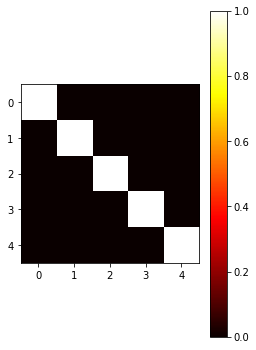

in: 
集之文雅风骚句
model answer: 
以予道德气贯天
desired answer: 
展以清新锦绣章




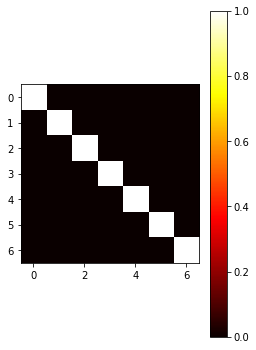

in: 
老病死，众生共业无非苦
model answer: 
干净土，吾道同心最可悲
desired answer: 
去来今，万法唯心毕竟空




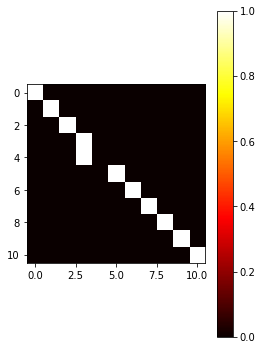

in: 
百年名校树嘉声，喜前程似锦，正圆美梦
model answer: 
一路春风扬特色，看小康如诗，纷卷浓新
desired answer: 
一路高歌追胜境，当大步流星，直上青云




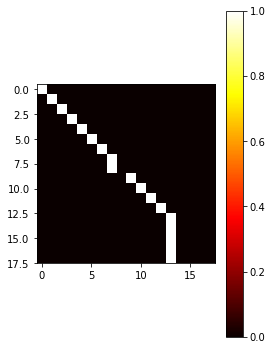

in: 
暮雨花残惜缘泪
model answer: 
晨风月冷知了心
desired answer: 
晨箫木楫离散诗




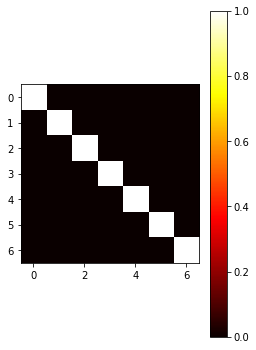

in: 
瓶露洒禅林，恩泽苍生，手眼布春荣万象
model answer: 
井冈思史册，名垂赤子，乡人秋道事儿奠
desired answer: 
莲台擎慧日，光开睿智，慈悲济世达三乘




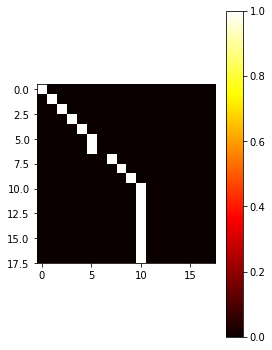

in: 
有福享高年，堂会八仙欣介寿
model answer: 
无忧添乐府，摒除百鸟共鸣春
desired answer: 
洪筹添满屋，图悬九老祝遐龄




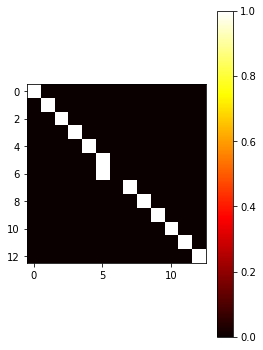

in: 
揽胜登楼，问贤圣凭谁俯仰
model answer: 
寻芳赏景，观奇石与我陶然
desired answer: 
临风追梦，放江山入我襟怀




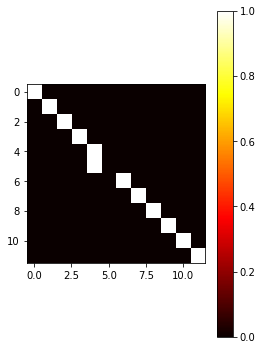

in: 
好色贪官频落马
model answer: 
痴情傻子总吃香
desired answer: 
多情少妇爱牵牛




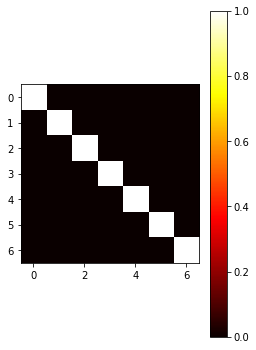

in: 
以仁义为师，行止堪追至圣
model answer: 
凭道德作客，和平不让名臣
desired answer: 
有图书做伴，厅堂亦是尼山




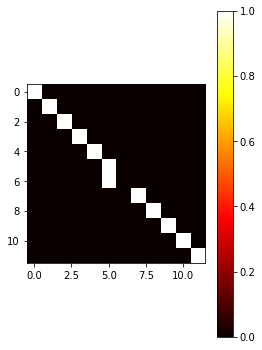

In [12]:
evaluateRandomly(char2tone_dict,encoder, attn_decoder,forced_tone=True,forced_word=True,beam_width=1,n=10)